### 迁移学习 -- 猫狗分类

#### 下载模型 
（https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5）

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_model = "model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_model)

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer("mixed7")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


#### 设置损失函数、优化算法和dropout

In [2]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics = ['acc'])

#### 猫狗数据集准备、图像增强

In [3]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 解压数据
local_zip = "E:/02Studying/03DeepLearning/dataset/jupyter/05CatDog/cats_and_dogs_filtered.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('E:/02Studying/03DeepLearning/dataset/jupyter/05CatDog')
zip_ref.close()

# 划分数据
base_dir = 'E:/02Studying/03DeepLearning/dataset/jupyter/05CatDog/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir , 'train')
val_dir = os.path.join(base_dir , 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
val_cats_dir = os.path.join(val_dir, 'cats')
val_dogs_dir = os.path.join(val_dir, 'dogs')

# 显示数据数量
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

# 数据增强
train_datagen = ImageDataGenerator( 
                rescale = 1.0/255.,
                rotation_range=40,     # 0~40°之间随机旋转 
                width_shift_range=0.2,  # 随机移动
                height_shift_range=0.2, # 随机移动
                shear_range=0.2,        # 裁剪图片
                zoom_range=0.2,         # 放大图片
                horizontal_flip=True   # 镜像
                )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# 生成数据
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
                                                    
val_generator =  test_datagen.flow_from_directory(val_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 训练

In [10]:
history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_steps=50,
                              verbose=2)

Epoch 1/20
100/100 - 11s - loss: 0.1316 - acc: 0.9580 - val_loss: 0.1327 - val_acc: 0.9660
Epoch 2/20
100/100 - 11s - loss: 0.1354 - acc: 0.9610 - val_loss: 0.1262 - val_acc: 0.9660
Epoch 3/20
100/100 - 11s - loss: 0.1380 - acc: 0.9550 - val_loss: 0.1850 - val_acc: 0.9480
Epoch 4/20
100/100 - 11s - loss: 0.1209 - acc: 0.9630 - val_loss: 0.1424 - val_acc: 0.9600
Epoch 5/20
100/100 - 11s - loss: 0.1177 - acc: 0.9640 - val_loss: 0.1345 - val_acc: 0.9680
Epoch 6/20
100/100 - 11s - loss: 0.1085 - acc: 0.9615 - val_loss: 0.1612 - val_acc: 0.9560
Epoch 7/20
100/100 - 11s - loss: 0.1203 - acc: 0.9585 - val_loss: 0.1163 - val_acc: 0.9700
Epoch 8/20
100/100 - 11s - loss: 0.1384 - acc: 0.9545 - val_loss: 0.1041 - val_acc: 0.9730
Epoch 9/20
100/100 - 11s - loss: 0.1038 - acc: 0.9695 - val_loss: 0.1234 - val_acc: 0.9680
Epoch 10/20
100/100 - 11s - loss: 0.1206 - acc: 0.9635 - val_loss: 0.1381 - val_acc: 0.9650
Epoch 11/20
100/100 - 11s - loss: 0.0882 - acc: 0.9675 - val_loss: 0.1636 - val_acc: 0.95

#### 显示训练集和验证集损失函数曲线和准确率曲线

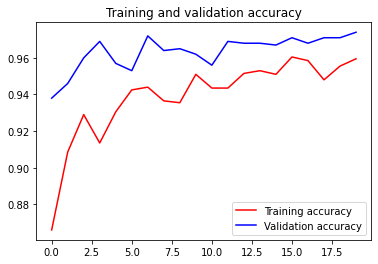

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

#### 清理内存，释放资源

In [ ]:
import os, signal

os.kill(     os.getpid() , 
         signal.SIGTERM
       )